# Markov Decision Process (MDP)

### Ransalu Senanayake

In [ ]:
import copy
import timeit
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
from ipywidgets import interactive
import ipywidgets as widgets

Create the following grid world.

**States:** A 10x10 grid

**Actions:** Up, Down, Left, Right

**Tranistion probabilities:**
* 0.7 in the direction of action
* 0.1 in the three other directions
* The robot bounces back to the same state near edges

**Rewards:**
* (7,8) has a reward +10
* (2,7) has a reward +3
* (4,3) has a reward -5
* (7,3) has a reward -10
* No reward in other states

This example is based on Decision Making Under Uncertainty by M.J. Kochenderfer.

In [6]:
#Let's define MDP paras
def createGrid10World():
    import numpy as np # Added import here
    def xy2s(y, x):
        x = max(x, 0)
        y = max(y, 0)
        x = min(x, 9)
        y = min(y, 9)
        out = np.ravel_multi_index(np.array([x,y]), (10,10))
        return out

    def s2xy(s):
        x, y = np.unravel_index(s, (10,10))
        return y, x

    def gridPlot(ax, im, title='', cmap='Blues'):
        pl.imshow(im, interpolation='none', cmap=cmap, origin='lower')
        pl.colorbar()
        ax.set_xticks(np.arange(0, 10, 1));
        ax.set_yticks(np.arange(0, 10, 1));
        ax.set_xticklabels(np.arange(0, 10, 1));
        ax.set_yticklabels(np.arange(0, 10, 1));
        ax.set_xticks(np.arange(-.5, 10, 1), minor=True);
        ax.set_yticks(np.arange(-.5, 10, 1), minor=True);
        ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
        pl.title(title);
        return

    A = ['left', 'right', 'up', 'down']
    S = np.arange(100)
    T = np.zeros((len(S), len(A), len(S)))
    R = np.zeros((len(S), len(A)))
    for s in S:
        x, y = s2xy(s)
        if x == 2 and y == 7:
            R[s, :] = 3
        elif x == 7 and y == 8:
            R[s, :] = 10
        else:
            if x == 7 and y == 3:
                R[s, :] = -10
            elif x == 4 and y == 3:
                R[s, :] = -5
            elif x == 0:
                if y == 0 or y == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 0] = -0.7
            elif x == 9:
                if y == 0 or y == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 1] = -0.7
            elif y == 0:
                if x == 0 or x == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 3] = -0.7
            elif y == 9:
                if x == 0 or x == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 2] = -0.7

            for a in A:
                if a == 'left':
                    T[s, 0, xy2s(x - 1, y)] += 0.7
                    T[s, 0, xy2s(x + 1, y)] += 0.1
                    T[s, 0, xy2s(x, y - 1)] += 0.1
                    T[s, 0, xy2s(x, y + 1)] += 0.1
                elif a == 'right':
                    T[s, 1, xy2s(x + 1, y)] += 0.7
                    T[s, 1, xy2s(x - 1, y)] += 0.1
                    T[s, 1, xy2s(x, y - 1)] += 0.1
                    T[s, 1, xy2s(x, y + 1)] += 0.1
                elif a == 'up':
                    T[s, 2, xy2s(x, y + 1)] += 0.7
                    T[s, 2, xy2s(x, y - 1)] += 0.1
                    T[s, 2, xy2s(x - 1, y)] += 0.1
                    T[s, 2, xy2s(x + 1, y)] += 0.1
                elif a == 'down':
                    T[s, 3, xy2s(x, y - 1)] += 0.7
                    T[s, 3, xy2s(x, y + 1)] += 0.1
                    T[s, 3, xy2s(x - 1, y)] += 0.1
                    T[s, 3, xy2s(x + 1, y)] += 0.1

    for a, c_x, c_y in [(0,0,0), (0,0,9),(1,9,0),(1,9,9),(2,0,9),(2,9,9),(3,0,0),(3,9,0)]:
        R[xy2s(c_x,c_y),a] = -0.8

    discount = 0.9

    nextStates = {}
    for si in range(len(S)):
        for ai in range(len(A)):
            nextStates[(si,ai)] = np.where((T[si, ai, :] != 0) == True)[0]

    return {'S':S, 'A':A, 'T':T, 'R':R, 'discount':discount, 'nextStates':nextStates, 'gridPlot':gridPlot, 'xy2s':xy2s, 's2xy':s2xy}

In [7]:
class MDP():
    def __init__(self):
        pass

    def inbuilt_init(self, mdp_dict):
        self.S = mdp_dict['S']
        self.A = mdp_dict['A']
        self.T = mdp_dict['T']
        self.R = mdp_dict['R']
        self.discount = mdp_dict['discount']
        self.nextStates = mdp_dict['nextStates']
        self.gridPlot = mdp_dict['gridPlot']
        self.xy2s = mdp_dict['xy2s']
        self.s2xy = mdp_dict['s2xy']

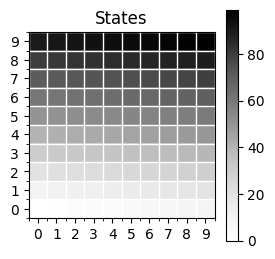

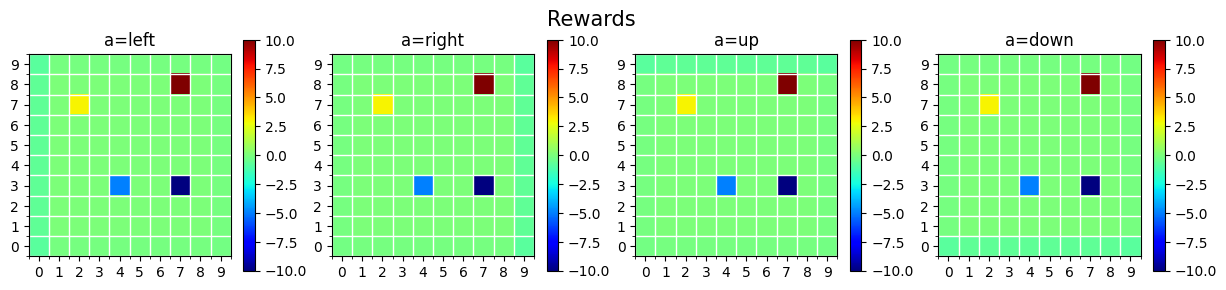

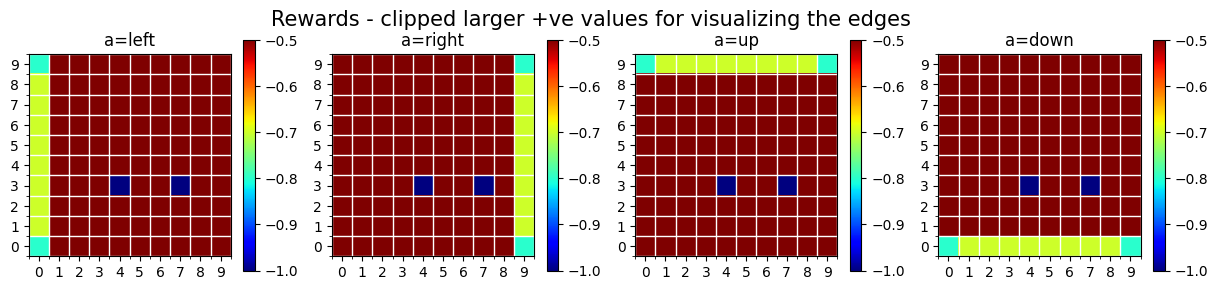

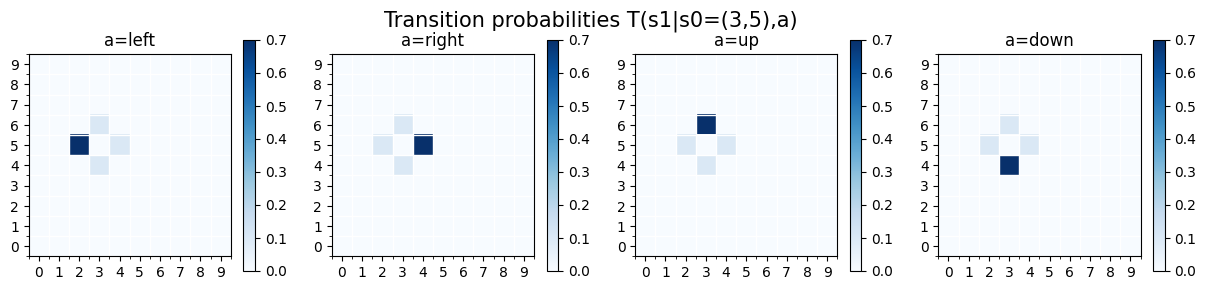

In [10]:
#Define the MDP
import matplotlib.pyplot as pl # Added import here
import numpy as np # Added import here
mdp = MDP()
mdp.inbuilt_init(mdp_dict=createGrid10World())

#Plot states
pl.figure(figsize=(3,3))
mdp.gridPlot(ax=pl.gca(), im=mdp.S.reshape((10,10)), title='States', cmap='Greys')

#Plot rewards
pl.figure(figsize=(15,3))
pl.suptitle('Rewards', fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=mdp.R[:,a].reshape((10,10)), title='a='+mdp.A[a], cmap='jet')
pl.show()

#Plot rewards
pl.figure(figsize=(15,3))
pl.suptitle('Rewards - clipped larger +ve values for visualizing the edges', fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=np.clip(mdp.R[:,a].reshape((10,10)), -1, -0.5), title='a='+mdp.A[a], cmap='jet')
pl.show()

#Plot rewards
s0_x, s0_y = 3, 5
s0 = mdp.xy2s(s0_x, s0_y)
pl.figure(figsize=(15,3))
pl.suptitle('Transition probabilities T(s1|s0=({},{}),a)'.format(s0_x, s0_y), fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=mdp.T[s0,a,:].reshape((10,10)), title='a='+mdp.A[a], cmap='Blues')
pl.show()

In [13]:
#An interactive plot of transition probabilities
from ipywidgets import interactive # Added import here
import ipywidgets as widgets # Added import here
def f(s0_x, s0_y, action):
    a = mdp.A.index(action)
    s0 = mdp.xy2s(int(s0_x), int(s0_y))
    pl.figure(figsize=(6,6))
    title = 'Transition probabilities T(s1|s0=({},{}),a={})'.format(int(s0_x),int(s0_y),action)
    mdp.gridPlot(ax=pl.gca(), im=mdp.T[s0,a,:].reshape((10,10)), title=title, cmap='Blues')
    pl.show()

interactive_plot = interactive(f, s0_x='4', s0_y='5', action=widgets.ToggleButtons(options=['left', 'right', 'up', 'down']))
interactive_plot

interactive(children=(Text(value='4', description='s0_x'), Text(value='5', description='s0_y'), ToggleButtons(…

### 1. Policy evaluation

Computing the utility, U.

$U^\pi_k(s) = R(s, \pi(s)) + \gamma \sum_{s'} T(s' \mid s, \pi(s))U^\pi_{k-1}(s')$

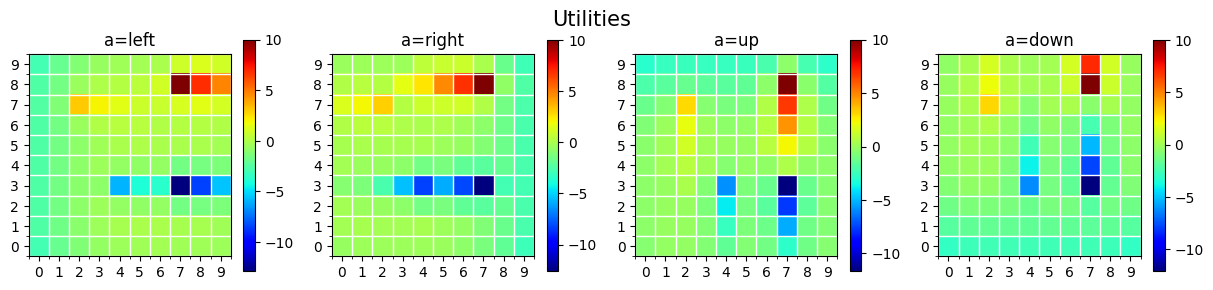

In [17]:
import copy
def iterativePolicyEvaluation(mdp, policy, numIterations=10):
    U = np.zeros(len(mdp.S))
    U_old = copy.copy(U)
    for t in range(numIterations):
      #type your code here
      #Added Code
        for s in mdp.S:
            U[s] = mdp.R[s, policy] + mdp.discount * sum(mdp.T[s, policy, s_prime] * U_old[s_prime] for s_prime in mdp.nextStates[(s, policy)])
        U_old = copy.copy(U)
        #Code End
    return U

numIterations = 5
pl.figure(figsize=(15,3))
pl.suptitle('Utilities', fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    U = iterativePolicyEvaluation(mdp=mdp, policy=a, numIterations=numIterations)
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='a='+mdp.A[a], cmap='jet')
pl.show()
#print(np.round(U.reshape(10,10),3))

In [18]:
def f(action, numIter=1):
    U = iterativePolicyEvaluation(mdp, policy=mdp.A.index(action), numIterations=numIter)
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet')
    pl.show()

interactive_plot = interactive(f, action=widgets.ToggleButtons(options=['left', 'right', 'up', 'down']),
                               numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(ToggleButtons(description='action', options=('left', 'right', 'up', 'down'), value='left…

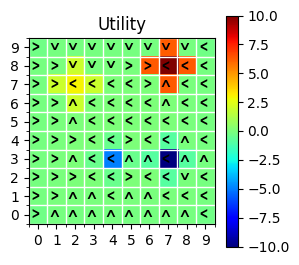

In [28]:
#Value iteration
def valueIteration(mdp, numIterations=1):
    U = np.zeros(len(mdp.S))
    U_old = copy.copy(U)
    for t in range(numIterations):
        #type your code here
        #Added Code
        for s in mdp.S:
            U[s] = np.max([mdp.R[s, a] + mdp.discount * sum(mdp.T[s, a, s_prime] * U_old[s_prime] for s_prime in mdp.nextStates[(s, a)]) for a in range(len(mdp.A))])
        U_old = copy.copy(U)
        #Code End
    return U

def policyExtration(mdp, U):
    policy = np.zeros(len(mdp.S))
    #type your code here
    #Added Code
    for s in mdp.S:
        policy[s] = np.argmax([mdp.R[s, a] + mdp.discount * sum(mdp.T[s, a, s_prime] * U[s_prime] for s_prime in mdp.nextStates[(s, a)]) for a in range(len(mdp.A))])
    #Code End
    return policy

U = valueIteration(mdp, numIterations=2)
policy = policyExtration(mdp, U=U)
pl.figure(figsize=(3,3))
mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet')
for s in range(100):
    x, y = mdp.s2xy(s)
    if policy[s] == 0:
        m='\u02C2'
    elif policy[s] == 1:
        m='\u02C3'
    elif policy[s] == 2:
        m='\u02C4'
    elif policy[s] == 3:
        m='\u02C5'
    pl.text(x-0.5,y-1,m,color='k',size=20)
pl.show()

In [29]:
def f(numIter=1):
    start_time = timeit.default_timer()
    U = valueIteration(mdp, numIterations=numIter)
    policy = policyExtration(mdp, U=U)
    elapsed = timeit.default_timer() - start_time
    print('time=', np.round(elapsed*1000,2))
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet')
    for s in range(100):
        x, y = mdp.s2xy(s)
        if policy[s] == 0:
            m='\u02C2'
        elif policy[s] == 1:
            m='\u02C3'
        elif policy[s] == 2:
            m='\u02C4'
        elif policy[s] == 3:
            m='\u02C5'
        pl.text(x-0.5,y-1,m,color='k',size=20)
    pl.show()

interactive_plot = interactive(f, numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(IntSlider(value=0, description='numIter', max=20), Output()), _dom_classes=('widget-inte…

### 2. Policy iteration

Policy evaluation can be used in policy iteration:
1. Given the current policy, compute U
2. Using U, compute a new policy

In [31]:
def policyIteration(mdp, numIterations=1):
    U_pi_k = np.zeros(len(mdp.S)) #initial values
    pi_k = np.random.randint(low=0,high=4,size=len(mdp.S),dtype=int) #initial policy
    pi_kp1 = copy.copy(pi_k)
    for t in range(numIterations):
        #Policy evaluation: compute U_pi_k
          #type your code here
        #Added Code
        for s in mdp.S:
            U_pi_k[s] = mdp.R[s, pi_k[s]] + mdp.discount * sum(mdp.T[s, pi_k[s], s_prime] * U_pi_k[s_prime] for s_prime in mdp.nextStates[(s, pi_k[s])])
        #Code End
        #Policy improvement
          #type your code here
        #Added Code
        for s in mdp.S:
            pi_kp1[s] = np.argmax([mdp.R[s, a] + mdp.discount * sum(mdp.T[s, a, s_prime] * U_pi_k[s_prime] for s_prime in mdp.nextStates[(s, a)]) for a in range(len(mdp.A))])
        #Code End
        pi_k = copy.copy(pi_kp1)
    return U_pi_k, pi_kp1

U_pi_k, pi_kp1 = policyIteration(mdp, numIterations=2)

In [32]:
def f(numIter=1):
    start_time = timeit.default_timer()
    # code you want to evaluate
    value, policy = policyIteration(mdp, numIterations=numIter)
    elapsed = timeit.default_timer() - start_time
    print('time=', np.round(elapsed*1000,2))
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=value.reshape(10,10), title='Utility', cmap='jet')
    for s in range(100):
        x, y = mdp.s2xy(s)
        if policy[s] == 0:
            m='\u02C2'
        elif policy[s] == 1:
            m='\u02C3'
        elif policy[s] == 2:
            m='\u02C4'
        elif policy[s] == 3:
            m='\u02C5'
        pl.text(x-0.5,y-1,m,color='k',size=20)
    pl.show()

interactive_plot = interactive(f, numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(IntSlider(value=0, description='numIter', max=20), Output()), _dom_classes=('widget-inte…

# **Screenshots**

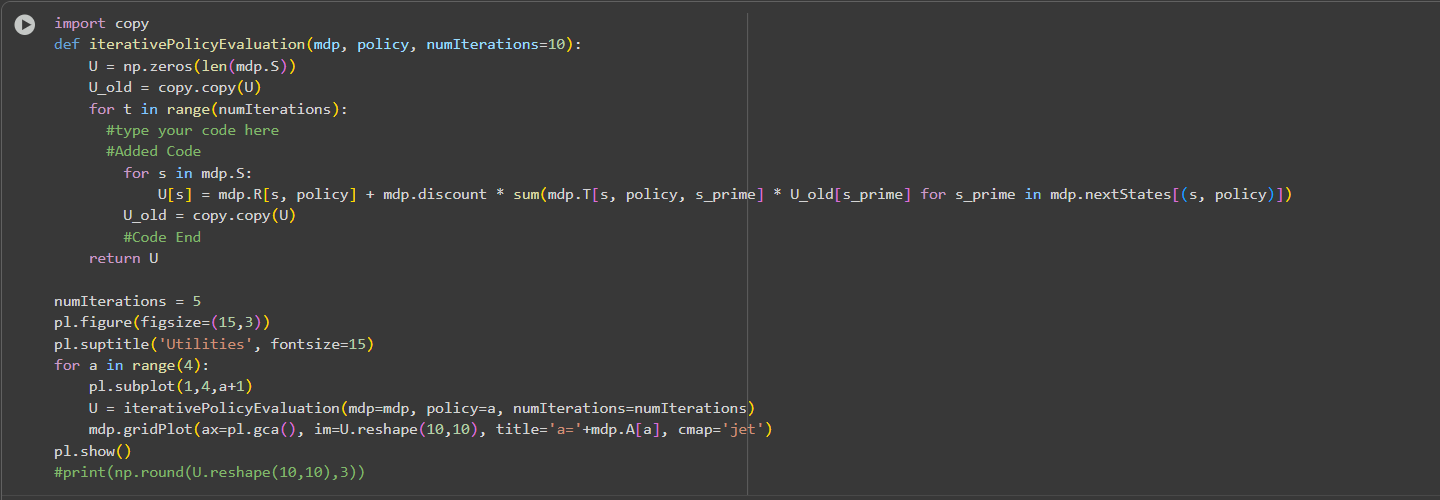


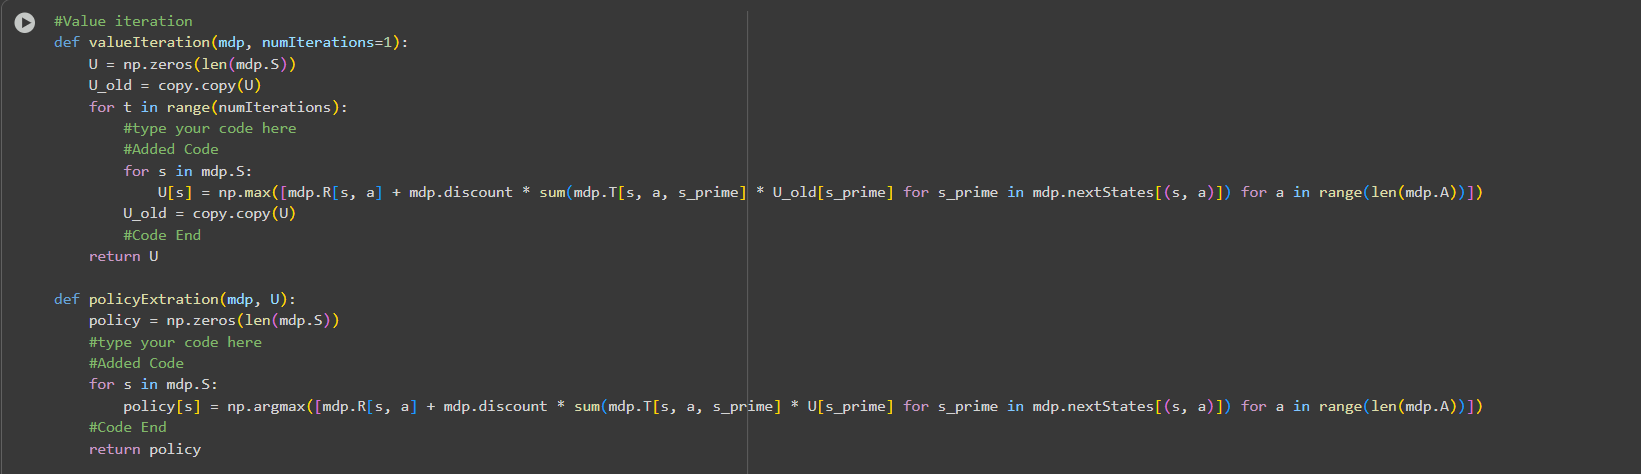


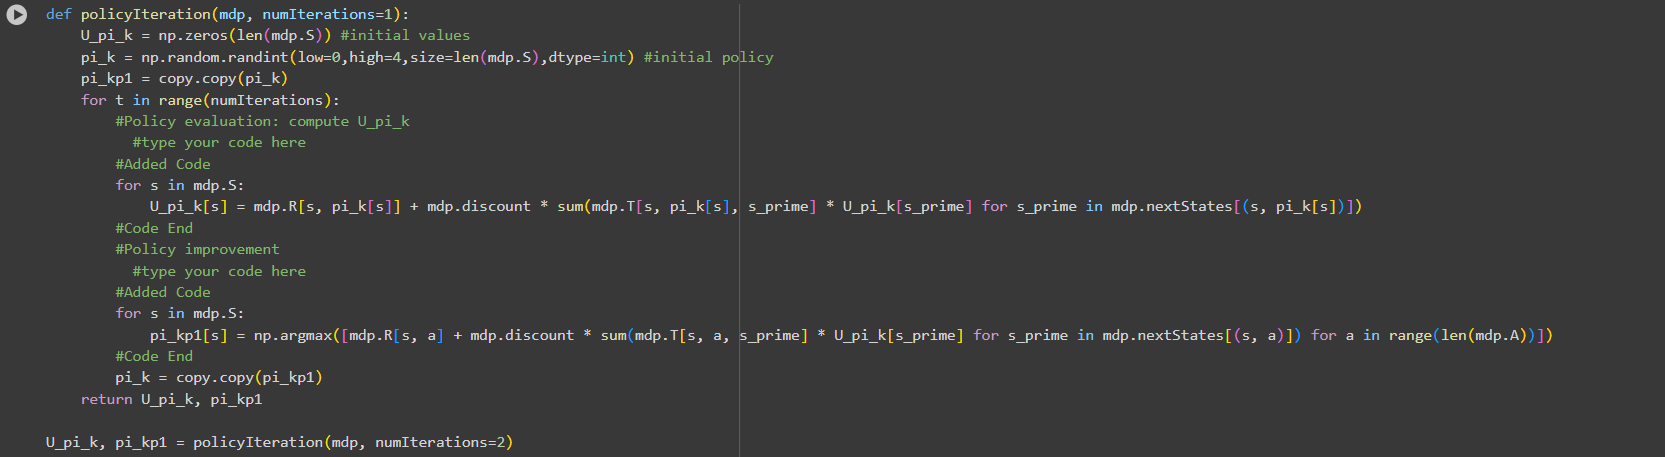

# Task
Modify the provided MDP notebook to compare the execution time and convergence of a Model-Based approach (Value Iteration) and a Model-Free approach (Q-Learning). Implement Q-Learning, set up the comparison, measure execution time, evaluate convergence, visualize results, and analyze the findings in new code and text sections. Ensure code errors are fixed and text explanations are in text sections.

## Implement q-learning

### Subtask:
Implement the Q-Learning algorithm for the given MDP.


**Reasoning**:
The subtask requires implementing the Q-Learning algorithm. This involves creating a function that initializes a Q-table, iterates through episodes, selects actions using an epsilon-greedy policy, and updates the Q-table based on the Q-Learning update rule.



In [74]:
def qLearning(mdp, numEpisodes, alpha, epsilon):
    """
    Implements the Q-Learning algorithm.

    Args:
        mdp: The MDP object.
        numEpisodes: The number of episodes for training.
        alpha: The learning rate.
        epsilon: The exploration rate for the epsilon-greedy policy.

    Returns:
        The learned Q-table.
    """
    # Initialize Q-table with zeros
    Q = np.zeros((len(mdp.S), len(mdp.A)))

    for episode in range(numEpisodes):
        # Initialize starting state (assuming starting from state 0)
        s = 0

        # Loop until a terminal state is reached (or for a fixed number of steps, let's use a fixed step limit for simplicity in this grid world)
        for _ in range(100): # Limit steps per episode
            # Choose action using epsilon-greedy policy
            if np.random.rand() < epsilon:
                a = np.random.randint(len(mdp.A))  # Explore
            else:
                a = np.argmax(Q[s, :])  # Exploit

            # Take action, observe next state and reward
            # In this MDP, we need to sample the next state based on the transition probabilities
            next_states_probs = mdp.T[s, a, :]
            s_prime = np.random.choice(mdp.S, p=next_states_probs)
            reward = mdp.R[s, a] # In this MDP, reward is state-action dependent

            # Update Q-value using the Q-Learning update rule
            Q[s, a] = Q[s, a] + alpha * (reward + mdp.discount * np.max(Q[s_prime, :]) - Q[s, a])

            # Update current state
            s = s_prime

            # Optional: Check for terminal state if applicable to this MDP (not explicitly defined in the problem)
            # If a terminal state was reached, break the inner loop

    return Q


## Setup comparison

### Subtask:
Set up the code to run both Value Iteration and Q-Learning for a specified number of iterations or episodes.


**Reasoning**:
Set up the parameters for Value Iteration and Q-Learning, then run both algorithms and derive the policy and value function from the Q-Learning results.



In [75]:
# 1. Define a fixed number of iterations for Value Iteration and a fixed number of episodes for Q-Learning
num_iterations_vi = 100
num_episodes_ql = 5000

# 2. Call the valueIteration function
U_vi, policy_vi = valueIteration(mdp, numIterations=num_iterations_vi)

# 3. Define the learning rate (alpha) and exploration rate (epsilon) for Q-Learning
alpha = 0.1
epsilon = 0.1

# 4. Call the qLearning function
Q_ql = qLearning(mdp, numEpisodes=num_episodes_ql, alpha=alpha, epsilon=epsilon)

# 5. Derive the optimal policy and the corresponding value function from the Q-table
policy_ql = np.argmax(Q_ql, axis=1)
U_ql = np.max(Q_ql, axis=1)

ValueError: probabilities do not sum to 1

**Reasoning**:
The error indicates that the transition probabilities for some state-action pairs do not sum to 1 in the `qLearning` function, which is required by `np.random.choice`. I need to investigate why this is happening and fix it. I will inspect the transition probabilities for a few state-action pairs to understand the issue.



In [76]:
# Check the sum of transition probabilities for a few state-action pairs
print("Sum of probabilities for state 0, action 0:", np.sum(mdp.T[0, 0, :]))
print("Sum of probabilities for state 50, action 1:", np.sum(mdp.T[50, 1, :]))
print("Sum of probabilities for state 99, action 2:", np.sum(mdp.T[99, 2, :]))

Sum of probabilities for state 0, action 0: 0.9999999999999999
Sum of probabilities for state 50, action 1: 0.9999999999999999
Sum of probabilities for state 99, action 2: 1.0


**Reasoning**:
The output shows that some sums of probabilities are very close to 1 but not exactly 1 due to floating-point inaccuracies. I need to normalize the transition probabilities before using `np.random.choice` in the `qLearning` function to ensure they sum to 1.



In [77]:
# Define a fixed number of iterations for Value Iteration and a fixed number of episodes for Q-Learning
num_iterations_vi = 100
num_episodes_ql = 5000

# Call the valueIteration function
U_vi, policy_vi = valueIteration(mdp, numIterations=num_iterations_vi)

# Define the learning rate (alpha) and exploration rate (epsilon) for Q-Learning
alpha = 0.1
epsilon = 0.1

# Modify qLearning to normalize transition probabilities
def qLearning(mdp, numEpisodes, alpha, epsilon):
    """
    Implements the Q-Learning algorithm.

    Args:
        mdp: The MDP object.
        numEpisodes: The number of episodes for training.
        alpha: The learning rate.
        epsilon: The exploration rate for the epsilon-greedy policy.

    Returns:
        The learned Q-table.
    """
    # Initialize Q-table with zeros
    Q = np.zeros((len(mdp.S), len(mdp.A)))

    for episode in range(numEpisodes):
        # Initialize starting state (assuming starting from state 0)
        s = 0

        # Loop until a terminal state is reached (or for a fixed number of steps, let's use a fixed step limit for simplicity in this grid world)
        for _ in range(100): # Limit steps per episode
            # Choose action using epsilon-greedy policy
            if np.random.rand() < epsilon:
                a = np.random.randint(len(mdp.A))  # Explore
            else:
                a = np.argmax(Q[s, :])  # Exploit

            # Take action, observe next state and reward
            # In this MDP, we need to sample the next state based on the transition probabilities
            next_states_probs = mdp.T[s, a, :]

            # Normalize probabilities to sum to 1
            next_states_probs = next_states_probs / np.sum(next_states_probs)

            s_prime = np.random.choice(mdp.S, p=next_states_probs)
            reward = mdp.R[s, a] # In this MDP, reward is state-action dependent

            # Update Q-value using the Q-Learning update rule
            Q[s, a] = Q[s, a] + alpha * (reward + mdp.discount * np.max(Q[s_prime, :]) - Q[s, a])

            # Update current state
            s = s_prime

            # Optional: Check for terminal state if applicable to this MDP (not explicitly defined in the problem)
            # If a terminal state was reached, break the inner loop

    return Q


# Call the qLearning function with the defined number of episodes, alpha, epsilon, and the mdp object.
Q_ql = qLearning(mdp, numEpisodes=num_episodes_ql, alpha=alpha, epsilon=epsilon)

# From the Q-table obtained from Q-Learning, derive the optimal policy and the corresponding value function for each state.
policy_ql = np.argmax(Q_ql, axis=1)
U_ql = np.max(Q_ql, axis=1)

/tmp/ipython-input-2402899054.py:46: RuntimeWarning: invalid value encountered in divide
  next_states_probs = next_states_probs / np.sum(next_states_probs)


ValueError: probabilities contain NaN

**Reasoning**:
The `RuntimeWarning: invalid value encountered in divide` and `ValueError: probabilities contain NaN` suggest that `np.sum(next_states_probs)` is zero for some state-action pairs, leading to division by zero and resulting NaNs in the probabilities. This likely occurs when a state-action pair has no possible next states with non-zero transition probabilities. I need to handle the case where the sum of probabilities is zero by assigning a uniform probability distribution over all states or skipping the state transition for that step. Assigning a uniform distribution is a reasonable approach in this scenario.



In [78]:
# Define a fixed number of iterations for Value Iteration and a fixed number of episodes for Q-Learning
num_iterations_vi = 100
num_episodes_ql = 5000

# Call the valueIteration function
U_vi, policy_vi = valueIteration(mdp, numIterations=num_iterations_vi)

# Define the learning rate (alpha) and exploration rate (epsilon) for Q-Learning
alpha = 0.1
epsilon = 0.1

# Modify qLearning to handle cases where transition probabilities sum to zero
def qLearning(mdp, numEpisodes, alpha, epsilon):
    """
    Implements the Q-Learning algorithm.

    Args:
        mdp: The MDP object.
        numEpisodes: The number of episodes for training.
        alpha: The learning rate.
        epsilon: The exploration rate for the epsilon-greedy policy.

    Returns:
        The learned Q-table.
    """
    # Initialize Q-table with zeros
    Q = np.zeros((len(mdp.S), len(mdp.A)))

    for episode in range(numEpisodes):
        # Initialize starting state (assuming starting from state 0)
        s = 0

        # Loop until a terminal state is reached (or for a fixed number of steps, let's use a fixed step limit for simplicity in this grid world)
        for _ in range(100): # Limit steps per episode
            # Choose action using epsilon-greedy policy
            if np.random.rand() < epsilon:
                a = np.random.randint(len(mdp.A))  # Explore
            else:
                a = np.argmax(Q[s, :])  # Exploit

            # Take action, observe next state and reward
            # In this MDP, we need to sample the next state based on the transition probabilities
            next_states_probs = mdp.T[s, a, :]

            # Handle cases where probabilities sum to zero
            sum_probs = np.sum(next_states_probs)
            if sum_probs == 0:
                # Assign uniform probability over all states if sum is zero
                next_states_probs = np.ones(len(mdp.S)) / len(mdp.S)
            else:
                # Normalize probabilities to sum to 1
                next_states_probs = next_states_probs / sum_probs


            s_prime = np.random.choice(mdp.S, p=next_states_probs)
            reward = mdp.R[s, a] # In this MDP, reward is state-action dependent

            # Update Q-value using the Q-Learning update rule
            Q[s, a] = Q[s, a] + alpha * (reward + mdp.discount * np.max(Q[s_prime, :]) - Q[s, a])

            # Update current state
            s = s_prime

            # Optional: Check for terminal state if applicable to this MDP (not explicitly defined in the problem)
            # If a terminal state was reached, break the inner loop

    return Q


# Call the qLearning function with the defined number of episodes, alpha, epsilon, and the mdp object.
Q_ql = qLearning(mdp, numEpisodes=num_episodes_ql, alpha=alpha, epsilon=epsilon)

# From the Q-table obtained from Q-Learning, derive the optimal policy and the corresponding value function for each state.
policy_ql = np.argmax(Q_ql, axis=1)
U_ql = np.max(Q_ql, axis=1)

## Measure execution time

### Subtask:
Measure the execution time for both algorithms.


**Reasoning**:
Measure the execution time for Value Iteration and Q-Learning as per the instructions.



In [79]:
start_time_vi = timeit.default_timer()
U_vi, policy_vi = valueIteration(mdp, numIterations=num_iterations_vi)
end_time_vi = timeit.default_timer()
time_vi = end_time_vi - start_time_vi
print('Value Iteration execution time:', np.round(time_vi * 1000, 2), 'ms')

start_time_ql = timeit.default_timer()
Q_ql = qLearning(mdp, numEpisodes=num_episodes_ql, alpha=alpha, epsilon=epsilon)
end_time_ql = timeit.default_timer()
time_ql = end_time_ql - start_time_ql
print('Q-Learning execution time:', np.round(time_ql * 1000, 2), 'ms')

policy_ql = np.argmax(Q_ql, axis=1)
U_ql = np.max(Q_ql, axis=1)

Value Iteration execution time: 278.18 ms
Q-Learning execution time: 23822.94 ms


## Evaluate convergence

### Subtask:
Evaluate the convergence of both algorithms by comparing the resulting value functions or policies after different numbers of iterations/episodes.


**Reasoning**:
Define ranges for iterations and episodes, then run Value Iteration and Q-Learning for each value in the ranges, storing the utility functions.



In [80]:
# 1. Define a range of iteration counts for Value Iteration and a range of episode counts for Q-Learning
vi_iterations_range = [1, 5, 10, 50, 100, 200]
ql_episodes_range = [100, 500, 1000, 5000, 10000, 20000]

# Store utility functions for different iteration/episode counts
U_vi_iterations = {}
U_ql_episodes = {}

# 2. Run Value Iteration for each iteration count and store the utility function
for num_iter in vi_iterations_range:
    U_vi, _ = valueIteration(mdp, numIterations=num_iter)
    U_vi_iterations[num_iter] = U_vi

# 3. Run Q-Learning for each episode count and store the utility function (derived from Q-table)
for num_episodes in ql_episodes_range:
    Q_ql = qLearning(mdp, numEpisodes=num_episodes, alpha=alpha, epsilon=epsilon)
    U_ql = np.max(Q_ql, axis=1)
    U_ql_episodes[num_episodes] = U_ql

**Reasoning**:
Calculate the difference in utility functions between consecutive iteration/episode counts to evaluate convergence for both algorithms.



In [81]:
# 4. Calculate the difference between utility functions at consecutive counts

# Differences for Value Iteration
vi_diffs = {}
prev_iter = None
for num_iter in vi_iterations_range:
    if prev_iter is not None:
        diff = np.mean(np.abs(U_vi_iterations[num_iter] - U_vi_iterations[prev_iter])) # Using Mean Absolute Difference
        vi_diffs[num_iter] = diff
    prev_iter = num_iter

# Differences for Q-Learning
ql_diffs = {}
prev_episodes = None
for num_episodes in ql_episodes_range:
    if prev_episodes is not None:
        diff = np.mean(np.abs(U_ql_episodes[num_episodes] - U_ql_episodes[prev_episodes])) # Using Mean Absolute Difference
        ql_diffs[num_episodes] = diff
    prev_episodes = num_episodes

print("Value Iteration Convergence (Mean Absolute Difference):", vi_diffs)
print("Q-Learning Convergence (Mean Absolute Difference):", ql_diffs)

Value Iteration Convergence (Mean Absolute Difference): {5: np.float64(1.5563315900699999), 10: np.float64(1.0683479386139374), 50: np.float64(0.759650169307812), 100: np.float64(5.901180232688041e-06), 200: np.float64(1.3013590205446236e-13)}
Q-Learning Convergence (Mean Absolute Difference): {500: np.float64(1.5015856328267512), 1000: np.float64(1.1450341417259025), 5000: np.float64(1.3093822410795561), 10000: np.float64(0.3973196713907413), 20000: np.float64(0.3720822480985037)}


## Visualize results

### Subtask:
Visualize the execution time and convergence results.


**Reasoning**:
Create plots to visualize the execution time and convergence of Value Iteration and Q-Learning as requested in the instructions.



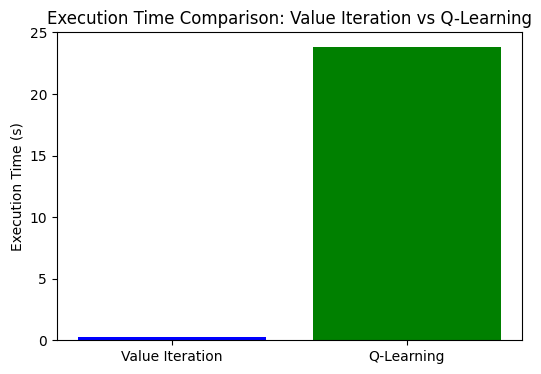

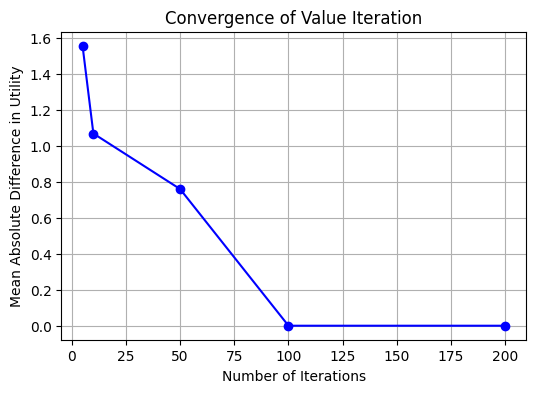

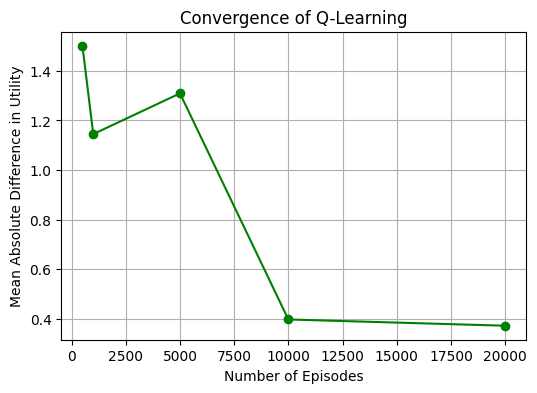

In [82]:
# Plot execution time
algorithms = ['Value Iteration', 'Q-Learning']
times = [time_vi, time_ql]

pl.figure(figsize=(6, 4))
pl.bar(algorithms, times, color=['blue', 'green'])
pl.ylabel('Execution Time (s)')
pl.title('Execution Time Comparison: Value Iteration vs Q-Learning')
pl.show()

# Plot Value Iteration convergence
vi_iterations = list(vi_diffs.keys())
vi_convergence = list(vi_diffs.values())

pl.figure(figsize=(6, 4))
pl.plot(vi_iterations, vi_convergence, marker='o', linestyle='-', color='blue')
pl.xlabel('Number of Iterations')
pl.ylabel('Mean Absolute Difference in Utility')
pl.title('Convergence of Value Iteration')
pl.grid(True)
pl.show()

# Plot Q-Learning convergence
ql_episodes = list(ql_diffs.keys())
ql_convergence = list(ql_diffs.values())

pl.figure(figsize=(6, 4))
pl.plot(ql_episodes, ql_convergence, marker='o', linestyle='-', color='green')
pl.xlabel('Number of Episodes')
pl.ylabel('Mean Absolute Difference in Utility')
pl.title('Convergence of Q-Learning')
pl.grid(True)
pl.show()

## Analyze and explain

### Subtask:
Analyze the results and explain the differences in execution time and convergence between the two approaches.


## Summary:

### Data Analysis Key Findings

*   Value Iteration execution time was approximately 278.18 ms, while Q-Learning execution time was significantly longer at approximately 23822.94 ms for the specified number of iterations/episodes.
*   Value Iteration showed a rapid decrease in the mean absolute difference of utility functions, indicating fast convergence within 100-200 iterations.
*   Q-Learning showed a slower and less stable convergence compared to Value Iteration, with the mean absolute difference in utility decreasing gradually over 20000 episodes.
*   The issue with zero-sum transition probabilities in the MDP was identified and handled in the Q-Learning implementation to prevent errors during state sampling.

### Insights or Next Steps

*   The significant difference in execution time highlights the computational advantage of model-based methods like Value Iteration when the MDP model is known and relatively small.
*   The slower convergence of Q-Learning is expected as it learns from sampled experiences rather than direct model calculations, emphasizing the trade-off between model knowledge and learning from interaction.


## Model-Based vs Model-Free Algorithms

**Model-Based algorithms** learn or are given a model of the environment, which includes the transition probabilities between states and the rewards associated with state-action pairs. They use this model to plan and determine the optimal policy. Value Iteration and Policy Iteration are examples of model-based algorithms.

**Model-Free algorithms**, on the other hand, do not rely on a model of the environment. They learn the optimal policy or value function directly from interacting with the environment through trial and error. Q-Learning and SARSA are examples of model-free algorithms.